# 1.앞서 roc값이 거의 50정도에 수렴하는 것을 알 수 있었다. 이 정확도를 어떻게 하면 좋게 만들 수 있는지 알아보자.

In [1]:
#'성능 개선'에는 여러가지 주식 종목을 돌아가면서 테스트 할 필요가 없기 때문에, 인텔 주식의 데이터로 주식 종목을 고정한다.
#또한, 성능 개선에만 초점을 맞췄기에, 필요없는 코드, 코드 부연 설명은 최대한 배제했다.

In [2]:
import pandas as pd 
import pandas_datareader as pdr
import talib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler

In [4]:
import numpy as np
import tensorflow as tf
import random as python_random

seed_number = 7
np.random.seed(seed_number)
python_random.seed(seed_number)
#tf.set_random_seed(seed_number) # v1
tf.random.set_seed(seed_number) # v2

In [5]:
df = pd.read_csv('intc.csv',
                 index_col='Date',
                 parse_dates=True)
sox_df = pd.read_csv('sox_df.csv',
                     index_col='Date',
                     parse_dates=True)
vix_df = pd.read_csv('vix_df.csv',
                     index_col='Date',
                     parse_dates=True)
snp500_df = pd.read_csv('s&p500.csv',
                        index_col='Date',
                        parse_dates=True)

In [6]:
df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
# Moving Average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

# Momentum Indicators
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators 

#4.ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left')
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

In [7]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,next_price,next_rtn,log_return,CCI,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,26.504349,28.013699,-0.017897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1469.250000,704.559998,24.639999
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,28.013699,26.705585,0.044849,0.055385,NaN,...,NaN,NaN,NaN,2.34375,NaN,NaN,NaN,1455.219971,713.200012,24.209999
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,26.705585,26.926966,-0.029261,-0.047821,NaN,...,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,1399.420044,687.320007,27.010000
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,26.926966,25.357227,0.007530,0.008255,NaN,...,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN,1402.109985,678.539978,26.410000
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,25.357227,26.403713,-0.036697,-0.060064,NaN,...,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,1403.449951,669.330017,25.730000


In [8]:
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [110]:
phase_flag = '3'

if phase_flag == '1' :
    train_from = '1996-01-04'
    train_to = '2002-01-01'

    val_from = '2002-01-01'
    val_to = '2003-01-01'

    test_from = '2003-01-01'
    test_to = '2004-01-01'

elif phase_flag == '2' :
    train_from = '2004-01-01'
    train_to = '2010-01-01'

    val_from = '2010-01-01'
    val_to = '2011-01-01'

    test_from = '2011-01-01'
    test_to = '2011-01-01'
    
else : 
    train_from = '2011-01-01'
    train_to = '2017-01-01'

    val_from = '2017-01-01'
    val_to = '2018-01-01'

    test_from = '2018-01-01'
    test_to = '2019-01-01'

In [111]:
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [112]:
train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,21.010000,21.049999,20.780001,15.776821,58223800.0,-0.008597,0.070012,0.114145,21.981975,20.563025,...,20.944,20.962,-0.180000,-0.090000,7.474231,-78.021890,1271.869995,415.049988,17.610001,-0.007615
2011-01-04,21.120001,21.200001,21.049999,16.003826,75206200.0,0.014286,0.070556,0.114306,21.928213,20.561787,...,20.998,20.954,0.299999,0.129999,8.350405,-41.176497,1270.199951,415.579987,17.379999,0.001420
2011-01-05,21.190001,21.209999,20.900000,15.844926,61810500.0,-0.009979,0.083113,0.112674,21.890380,20.535620,...,20.998,20.938,-0.209999,-0.090000,7.055220,-65.476088,1276.560059,417.089996,17.020000,-0.011798
2011-01-06,20.670000,20.820000,20.549999,15.716295,116669000.0,-0.008151,0.096061,0.106796,21.803445,20.517555,...,20.948,20.926,-0.170000,-0.080000,5.058169,-76.595628,1273.849976,424.769989,17.400000,0.004838
2011-01-07,20.709999,20.770000,20.270000,15.633060,74806100.0,-0.005310,0.114265,0.100671,21.707883,20.498117,...,20.874,20.908,-0.110001,-0.490000,7.380458,-66.379359,1271.500000,425.760010,17.139999,-0.002414


In [113]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

In [114]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [115]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,21.010000,21.049999,20.780001,15.776821,58223800.0,-0.008597,0.070012,0.114145,21.981975,20.563025,...,0.445384,0.078291,0.069481,0.472973,0.467176,0.558742,0.219781,0.147242,0.144773,0.193471
2011-01-04,21.120001,21.200001,21.049999,16.003826,75206200.0,0.014286,0.070556,0.114306,21.928213,20.561787,...,0.450523,0.081219,0.069036,0.554054,0.500763,0.574202,0.588235,0.145818,0.145638,0.187367
2011-01-05,21.190001,21.209999,20.900000,15.844926,61810500.0,-0.009979,0.083113,0.112674,21.890380,20.535620,...,0.448316,0.081219,0.068148,0.467905,0.467176,0.551349,0.345239,0.151242,0.148102,0.177813
2011-01-06,20.670000,20.820000,20.549999,15.716295,116669000.0,-0.008151,0.096061,0.106796,21.803445,20.517555,...,0.441612,0.078508,0.067481,0.474662,0.468702,0.516113,0.234044,0.148931,0.160632,0.187898
2011-01-07,20.709999,20.770000,20.270000,15.633060,74806100.0,-0.005310,0.114265,0.100671,21.707883,20.498117,...,0.433309,0.074496,0.066482,0.484797,0.406107,0.557088,0.336206,0.146927,0.162248,0.180998


In [116]:
num_step = 5
num_unit = 200

In [117]:
def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))
    
    train_ydata = np.array(data[[feature_list[n]]])
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1))
    return x_batch, y_batch

In [118]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1
# LSTM할때 사용했던 소스코드.
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [119]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [120]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    713.0
1    792.0
dtype: float32
0    117.0
1    129.0
dtype: float32
0    120.0
1    126.0
dtype: float32


In [121]:
x_train.shape
# 이것은 전체 데이터를 242 rolling , 10 window, 2개 feature를 본다는 것이다.
# 2개 feature를 10개 묶음으로 보는데, 1칸씩 미루면서 보니 242개 데이터를 본다는 것이다.

(1505, 5, 22)

In [122]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [123]:
# LSTM 모델을 생성할 때, 층의 개수를 더하거나 뺌으로서 모델의 성능 변화를 파악한다.
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)


model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])



In [124]:
history = model.fit(x_train,y_train,epochs=20, batch_size=10, validation_data=(x_val, y_val))


Epoch 1/20
151/151 [==============================] - 18s 61ms/step - loss: 3.0399 - accuracy: 0.5003 - val_loss: 0.9144 - val_accuracy: 0.5122
Epoch 2/20
151/151 [==============================] - 8s 55ms/step - loss: 0.8303 - accuracy: 0.5103 - val_loss: 0.7239 - val_accuracy: 0.5163
Epoch 3/20
151/151 [==============================] - 8s 54ms/step - loss: 0.7570 - accuracy: 0.4744 - val_loss: 0.8336 - val_accuracy: 0.4756
Epoch 4/20
151/151 [==============================] - 8s 56ms/step - loss: 0.7329 - accuracy: 0.5103 - val_loss: 0.7621 - val_accuracy: 0.4675
Epoch 5/20
151/151 [==============================] - 8s 55ms/step - loss: 0.7346 - accuracy: 0.4917 - val_loss: 0.7494 - val_accuracy: 0.5163
Epoch 6/20
151/151 [==============================] - 8s 54ms/step - loss: 0.7205 - accuracy: 0.5362 - val_loss: 0.7408 - val_accuracy: 0.5041
Epoch 7/20
151/151 [==============================] - 8s 54ms/step - loss: 0.7331 - accuracy: 0.5050 - val_loss: 0.7175 - val_accuracy: 0.491

In [125]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

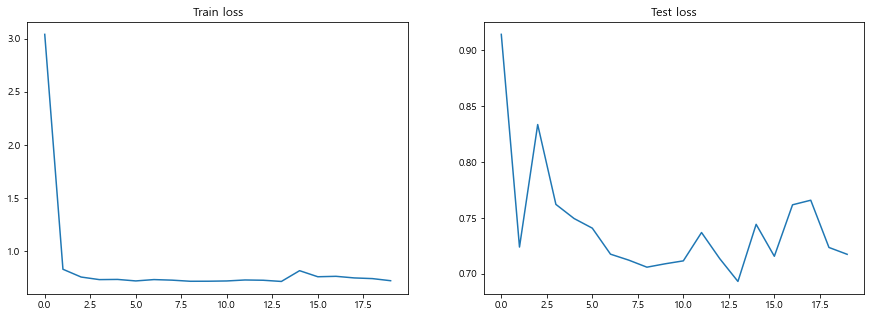

In [126]:
plot_history(history) # 3단계

In [127]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [128]:
predicted = model.predict(x_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

8/8 [==============================] - 2s 20ms/step


In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

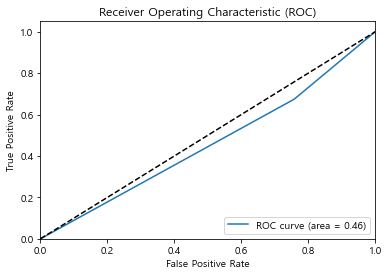

ROC AUC 값 : 0.4581


In [130]:
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

In [131]:
y_pred 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0], dtype=int64)

In [132]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계 test.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    20, 10))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

In [133]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

<AxesSubplot:xlabel='Date'>

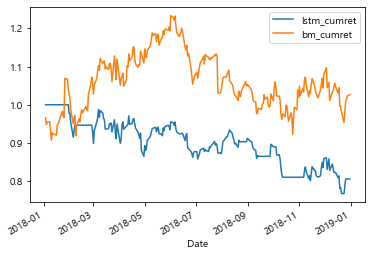

In [134]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

<AxesSubplot:xlabel='Date'>

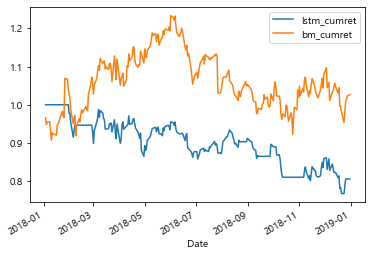

In [135]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

# Backtesting

<AxesSubplot:xlabel='Date'>

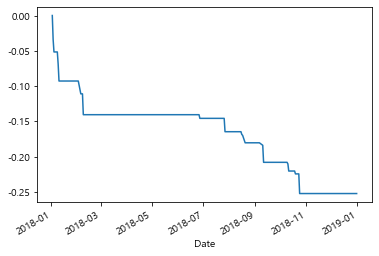

In [136]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

# BM

In [137]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  2.7 %
Sharpe :  0.25
VOL :  33.94 %
MDD :  25.23 %


# LSTM

In [138]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -19.5 %
Sharpe :  -0.81
VOL :  23.39 %
MDD :  25.23 %


# 2. 결과 산출

In [139]:
#LSTM 모델에서 층의 개수에 따른 ROC면적과 RM,LSTM의 CACR값

"""
1.층이 7개일 때 

0.54/-21.92%/-6.11 %


2.층이 9개일 때 

0.46/-21.92%/-13.54 %

결과가 더 나빠졌다!

원인:DROPOUT이 많아지면, 과적합 문제를 해결하기는 커녕 너무 많이 DROPOUT을 해버려서 모델의 성능이 더 안좋아진다.


3.층을 5개로(원래대로) 유지/ 데이터의 길이(TRAIN/TEST/VAILD 등)를 2배로 늘림

0.55/-29.29 %/33.58 %

(바이엔 홀딩을 했으면 30프로 손실, LSTM을 따르면 33프로 이득)

결과가 약간 더 좋아졌으나, 데이터 격차가 큰 편이여서 다른 방법을 찾아보거나 추후에 오류를 고쳐 나가는 과정이 더 중요할 것 같다.



"""

'\n1.층이 7개일 때 \n\n0.54/-21.92%/-6.11 %\n\n\n2.층이 9개일 때 \n\n0.46/-21.92%/-13.54 %\n\n결과가 더 나빠졌다!\n\n원인:DROPOUT이 많아지면, 과적합 문제를 해결하기는 커녕 너무 많이 DROPOUT을 해버려서 모델의 성능이 더 안좋아진다.\n\n\n3.층을 5개로(원래대로) 유지/ 데이터의 길이(TRAIN/TEST/VAILD 등)를 2배로 늘림\n\n0.55/-29.29 %/33.58 %\n\n(바이엔 홀딩을 했으면 30프로 손실, LSTM을 따르면 33프로 이득)\n\n결과가 약간 더 좋아졌으나, 데이터 격차가 큰 편이여서 다른 방법을 찾아보거나 추후에 오류를 고쳐 나가는 과정이 더 중요할 것 같다.\n\n\n\n'

# 3. 인사이트

1.LSTM 모델은 KNN보다 성능 개선이 더 어렵다. 하지만, 아예 안되는 것은 아니다. 데이터의 양을 늘리면 된다.
2.또한, 정확도의 절대저인 수치도 좋다고 보기 어렵다. 그러므로 프로젝트는 여기서 끝내되 성능을 개선할 수 있는 방법을 꾸준히 서칭하는 것이 가장 중요하다.
